# Import

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import silhouette_score, make_scorer
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
random_state = 42

# Data

In [3]:
data = pd.read_parquet('proc_data')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8636 entries, C10001 to C19190
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CRED

In [4]:
tsne_columns = [f"tsne{i+1}" for i in range(3)]
pca_columns = [f"pca{i+1}" for i in range(3)]
pca_tsne_cols = tsne_columns + pca_columns
num_features = [x for x in data.columns if x not in pca_tsne_cols]
print(f'{len(pca_tsne_cols)=}')
print(f'{len(num_features)=}')

len(pca_tsne_cols)=6
len(num_features)=17


In [5]:
features = data.drop(pca_tsne_cols, axis=1)
features.shape

(8636, 17)

In [6]:
features.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

# GridSearch Pipeline

In [ ]:
# не работает нихуя
# def silhouette_scorer(pipeline, X):
#     labels = pipeline.named_steps['cluster'].fit_predict(X)
#     score = silhouette_score(X, labels)
#     return score

# grid_search = GridSearchCV(
#     pipeline,
#     params_grid,
#     cv=3,
#     n_jobs=-1,
#     scoring=make_scorer(silhouette_scorer, greater_is_better=True)
# )
# grid_search.fit(features, [0]*8636)

In [74]:
params_grid = {
    'std': [StandardScaler(),  None],
    'normalize': [Normalizer(norm='l2'), Normalizer(norm='l1'), None],
    'pca': [
        PCA(n_components=3, random_state=random_state),
        PCA(n_components=2, random_state=random_state),
    ],
    'cluster': [
        KMeans(n_clusters=3, random_state=random_state),
        AgglomerativeClustering(n_clusters=3),
        HDBSCAN(min_cluster_size=1_000, max_cluster_size=2_500, min_samples=50),
    ]
}
def get_pipeline(params):
    pipeline = Pipeline(
        steps=[
            ('std', params['std']),
            ('normalize', params['normalize']),
            ('pca', params['pca']),
            ('cluster', params['cluster']),
        ]
    )
    return pipeline

def evaluate_silhouette(params, X):
    pipeline = get_pipeline(params)
    labels = pipeline.fit_predict(X)
    if len(set(labels)) < 2:
        return 0
    score = silhouette_score(X, labels)
    return score

def clustering_grid_search(params_grid, X):
    param_list = list(ParameterGrid(params_grid))
    best_score = -1
    best_params = None
    for params in tqdm(param_list):
        score = evaluate_silhouette(params, X)
        if score > best_score:
            best_score = score
            best_params = params
    return best_score, best_params

In [75]:
best_score, best_params = clustering_grid_search(params_grid, features[num_features])

100%|█████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:35<00:00,  1.03it/s]


In [76]:
best_score

0.5265962286208354

In [77]:
best_params

{'cluster': AgglomerativeClustering(n_clusters=3),
 'normalize': None,
 'pca': PCA(n_components=2, random_state=42),
 'std': None}

In [78]:
best_pipeline = get_pipeline(best_params)
best_pipeline

Pipeline(steps=[('std', None), ('normalize', None),
                ('pca', PCA(n_components=2, random_state=42)),
                ('cluster', AgglomerativeClustering(n_clusters=3))])

In [83]:
labels = best_pipeline.fit_predict(features[num_features])
features['cluster'] = labels
features['cluster'].value_counts()

cluster
3     3516
2     1849
8      912
0      592
7      429
13     384
6      294
9      270
10     138
4      118
11      68
5       35
12      16
1       15
Name: count, dtype: int64

In [92]:
def calc_pca(pipeline, X):
    _temp_result = None
    if hasattr(pipeline, 'std'):
        _temp_result = pipeline.named_steps['std'].transform(X)
    if hasattr(pipeline, 'normalize'):
        if _temp_result:
            _temp_result = pipeline.named_steps['normalize'].transform(_temp_result)
        else:
            _temp_result = pipeline.named_steps['normalize'].transform(X)
    if _temp_result:
        _pca = pipeline.named_steps['pca'].transform(_temp_result)
    else:
        _pca = pipeline.named_steps['pca'].transform(X)
    pca_result = pd.DataFrame(data=_pca)
    pca_result.columns = [f'pca{i+1}' for i in range(_pca.shape[1])]
    return pca_result

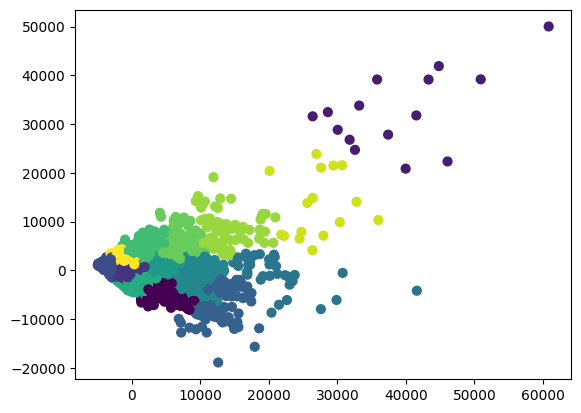

In [99]:
pca_result = calc_pca(best_pipeline, features[num_features])
pca_result['cluster'] = features.cluster.values
pca_cols = [col for col in pca_result.columns if col.startswith('pca')]
if len(pca_cols) == 3:
    px.scatter_3d(
        pca_result,
        x='pca1',
        y='pca2',
        z='pca3',
        color='cluster',
        # opacity=0.7,
    )
elif len(pca_cols) == 2:
    plt.scatter(x='pca1', y='pca2', c='cluster', s=40, cmap='viridis', data=pca_result)
    plt.show()

# Calc silhouette

In [84]:
%%time
def calc_silhouette(X, pipeline):
    silhouette_avg = list()
    for cluster_num in tqdm(range(2, 15)):
        if hasattr(pipeline.named_steps['cluster'], 'n_clusters'):
            pipeline.set_params(cluster__n_clusters=cluster_num)
        pipeline.fit(X)
        clusterer = pipeline.named_steps['cluster']
        labels = clusterer.labels_
        silhouette_avg.append(silhouette_score(X, labels))
    return silhouette_avg
silhouette_avg = calc_silhouette(features[num_features], best_pipeline)
silhouette_avg

100%|█████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.35s/it]

CPU times: user 38.9 s, sys: 41.3 s, total: 1min 20s
Wall time: 17.6 s


[0.559854103892781,
 0.5265962286208354,
 0.24475333055172088,
 0.24616859305421215,
 0.24743878017072515,
 0.2501303080746757,
 0.2544670709355706,
 0.21911495897194477,
 0.22173111556734712,
 0.2240765051190335,
 0.22546252583118384,
 0.22565890732389507,
 0.2005730645585281]

In [85]:
best_n_clusters = range(2,15)[np.argmax(silhouette_avg)+1]
best_n_clusters

3

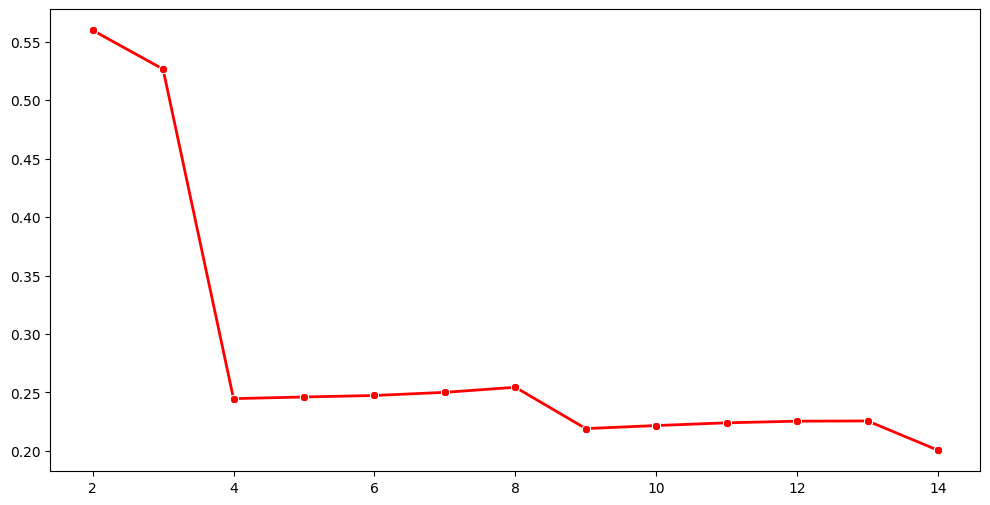

In [86]:
plt.figure(figsize=(12,6))
sns.lineplot(x=range(2,15),y=silhouette_avg,linewidth=2,color='red',marker='8')
plt.show()